# **hiii Every one !**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


In [2]:
pip install plotly


Note: you may need to restart the kernel to use updated packages.


<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">Dataset Analysis</p>


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import optuna
from optuna.samplers import TPESampler
import warnings
import shap
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report,log_loss
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix


In [4]:
test = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')
train = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')

In [5]:
train.head().style.set_properties(**{
    "background-color": "aqua", 
    "color": "#000000", 
    "border": "1.5px solid #5f0d11"
})

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.000000,Ludhiana,Working Professional,Chef,nan,5.000000,nan,nan,2.000000,More than 8 hours,Healthy,BHM,No,1.000000,2.000000,No,0
1,1,Vivan,Male,26.000000,Varanasi,Working Professional,Teacher,nan,4.000000,nan,nan,3.000000,Less than 5 hours,Unhealthy,LLB,Yes,7.000000,3.000000,No,1
2,2,Yuvraj,Male,33.000000,Visakhapatnam,Student,nan,5.000000,nan,8.970000,2.000000,nan,5-6 hours,Healthy,B.Pharm,Yes,3.000000,1.000000,No,1
3,3,Yuvraj,Male,22.000000,Mumbai,Working Professional,Teacher,nan,5.000000,nan,nan,1.000000,Less than 5 hours,Moderate,BBA,Yes,10.000000,1.000000,Yes,1
4,4,Rhea,Female,30.000000,Kanpur,Working Professional,Business Analyst,nan,1.000000,nan,nan,1.000000,5-6 hours,Unhealthy,BBA,Yes,9.000000,4.000000,Yes,0


In [6]:
test.head().style.set_properties(**{
    "background-color": "aqua", 
    "color": "#000000", 
    "border": "1.5px solid #5f0d11"
})

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,140700,Shivam,Male,53.000000,Visakhapatnam,Working Professional,Judge,nan,2.000000,nan,nan,5.000000,Less than 5 hours,Moderate,LLB,No,9.000000,3.000000,Yes
1,140701,Sanya,Female,58.000000,Kolkata,Working Professional,Educational Consultant,nan,2.000000,nan,nan,4.000000,Less than 5 hours,Moderate,B.Ed,No,6.000000,4.000000,No
2,140702,Yash,Male,53.000000,Jaipur,Working Professional,Teacher,nan,4.000000,nan,nan,1.000000,7-8 hours,Moderate,B.Arch,Yes,12.000000,4.000000,No
3,140703,Nalini,Female,23.000000,Rajkot,Student,nan,5.000000,nan,6.840000,1.000000,nan,More than 8 hours,Moderate,BSc,Yes,10.000000,4.000000,No
4,140704,Shaurya,Male,47.000000,Kalyan,Working Professional,Teacher,nan,5.000000,nan,nan,5.000000,7-8 hours,Moderate,BCA,Yes,3.000000,4.000000,No


In [7]:
# Get the number of unique values for each column
unique_counts = train.nunique().to_frame(name="Unique Counts")

# Apply styling to the DataFrame
unique_counts_styled = unique_counts.style.set_properties(**{
    "background-color": "aqua", 
    "color": "#000000", 
    "border": "1.5px solid #5f0d11"
})

unique_counts_styled


,Unique Counts
id,140700
Name,422
Gender,2
Age,43
City,98
Working Professional or Student,2
Profession,64
Academic Pressure,5
Work Pressure,5
CGPA,331


In [8]:
train.describe().style.set_properties(**{
    "background-color": "aqua", 
    "color": "#000000", 
    "border": "1.5px solid #5f0d11"
})

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.000000,140700.000000,27897.000000,112782.000000,27898.000000,27897.000000,112790.000000,140700.000000,140696.000000,140700.000000
mean,70349.500000,40.388621,3.142273,2.998998,7.658636,2.944940,2.974404,6.252679,2.988983,0.181713
std,40616.735775,12.384099,1.380457,1.405771,1.464466,1.360197,1.416078,3.853615,1.413633,0.385609
min,0.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,35174.750000,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,70349.500000,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,0.000000
75%,105524.250000,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000,0.000000
max,140699.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


**Categorical Dustribution**

In [9]:
train.describe(include='object').style.set_properties(**{
    "background-color": "aqua", 
    "color": "#000000", 
    "border": "1.5px solid #5f0d11"
})

,Name,Gender,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Family History of Mental Illness
count,140700,140700,140700,140700,104070,140700,140696,140698,140700,140700
unique,422,2,98,2,64,36,23,115,2,2
top,Rohan,Male,Kalyan,Working Professional,Teacher,Less than 5 hours,Moderate,Class 12,No,No
freq,3178,77464,6591,112799,24906,38784,49705,14729,71138,70758


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [11]:
print(train.columns.tolist())

['id', 'Name', 'Gender', 'Age', 'City', 'Working Professional or Student', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression']


In [12]:
depression_counts = train['Depression'].value_counts()
print(depression_counts)

Depression
0    115133
1     25567
Name: count, dtype: int64


In [13]:
print("Train rows --->",train.shape[0],"no's")
print("Train columns -->",train.shape[1],"no's")

print("Test rows --->",test.shape[0],"no's")
print("Test columns -->",test.shape[1],"no's")

Train rows ---> 140700 no's
Train columns --> 20 no's
Test rows ---> 93800 no's
Test columns --> 19 no's


<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">EDA PLOT</p>


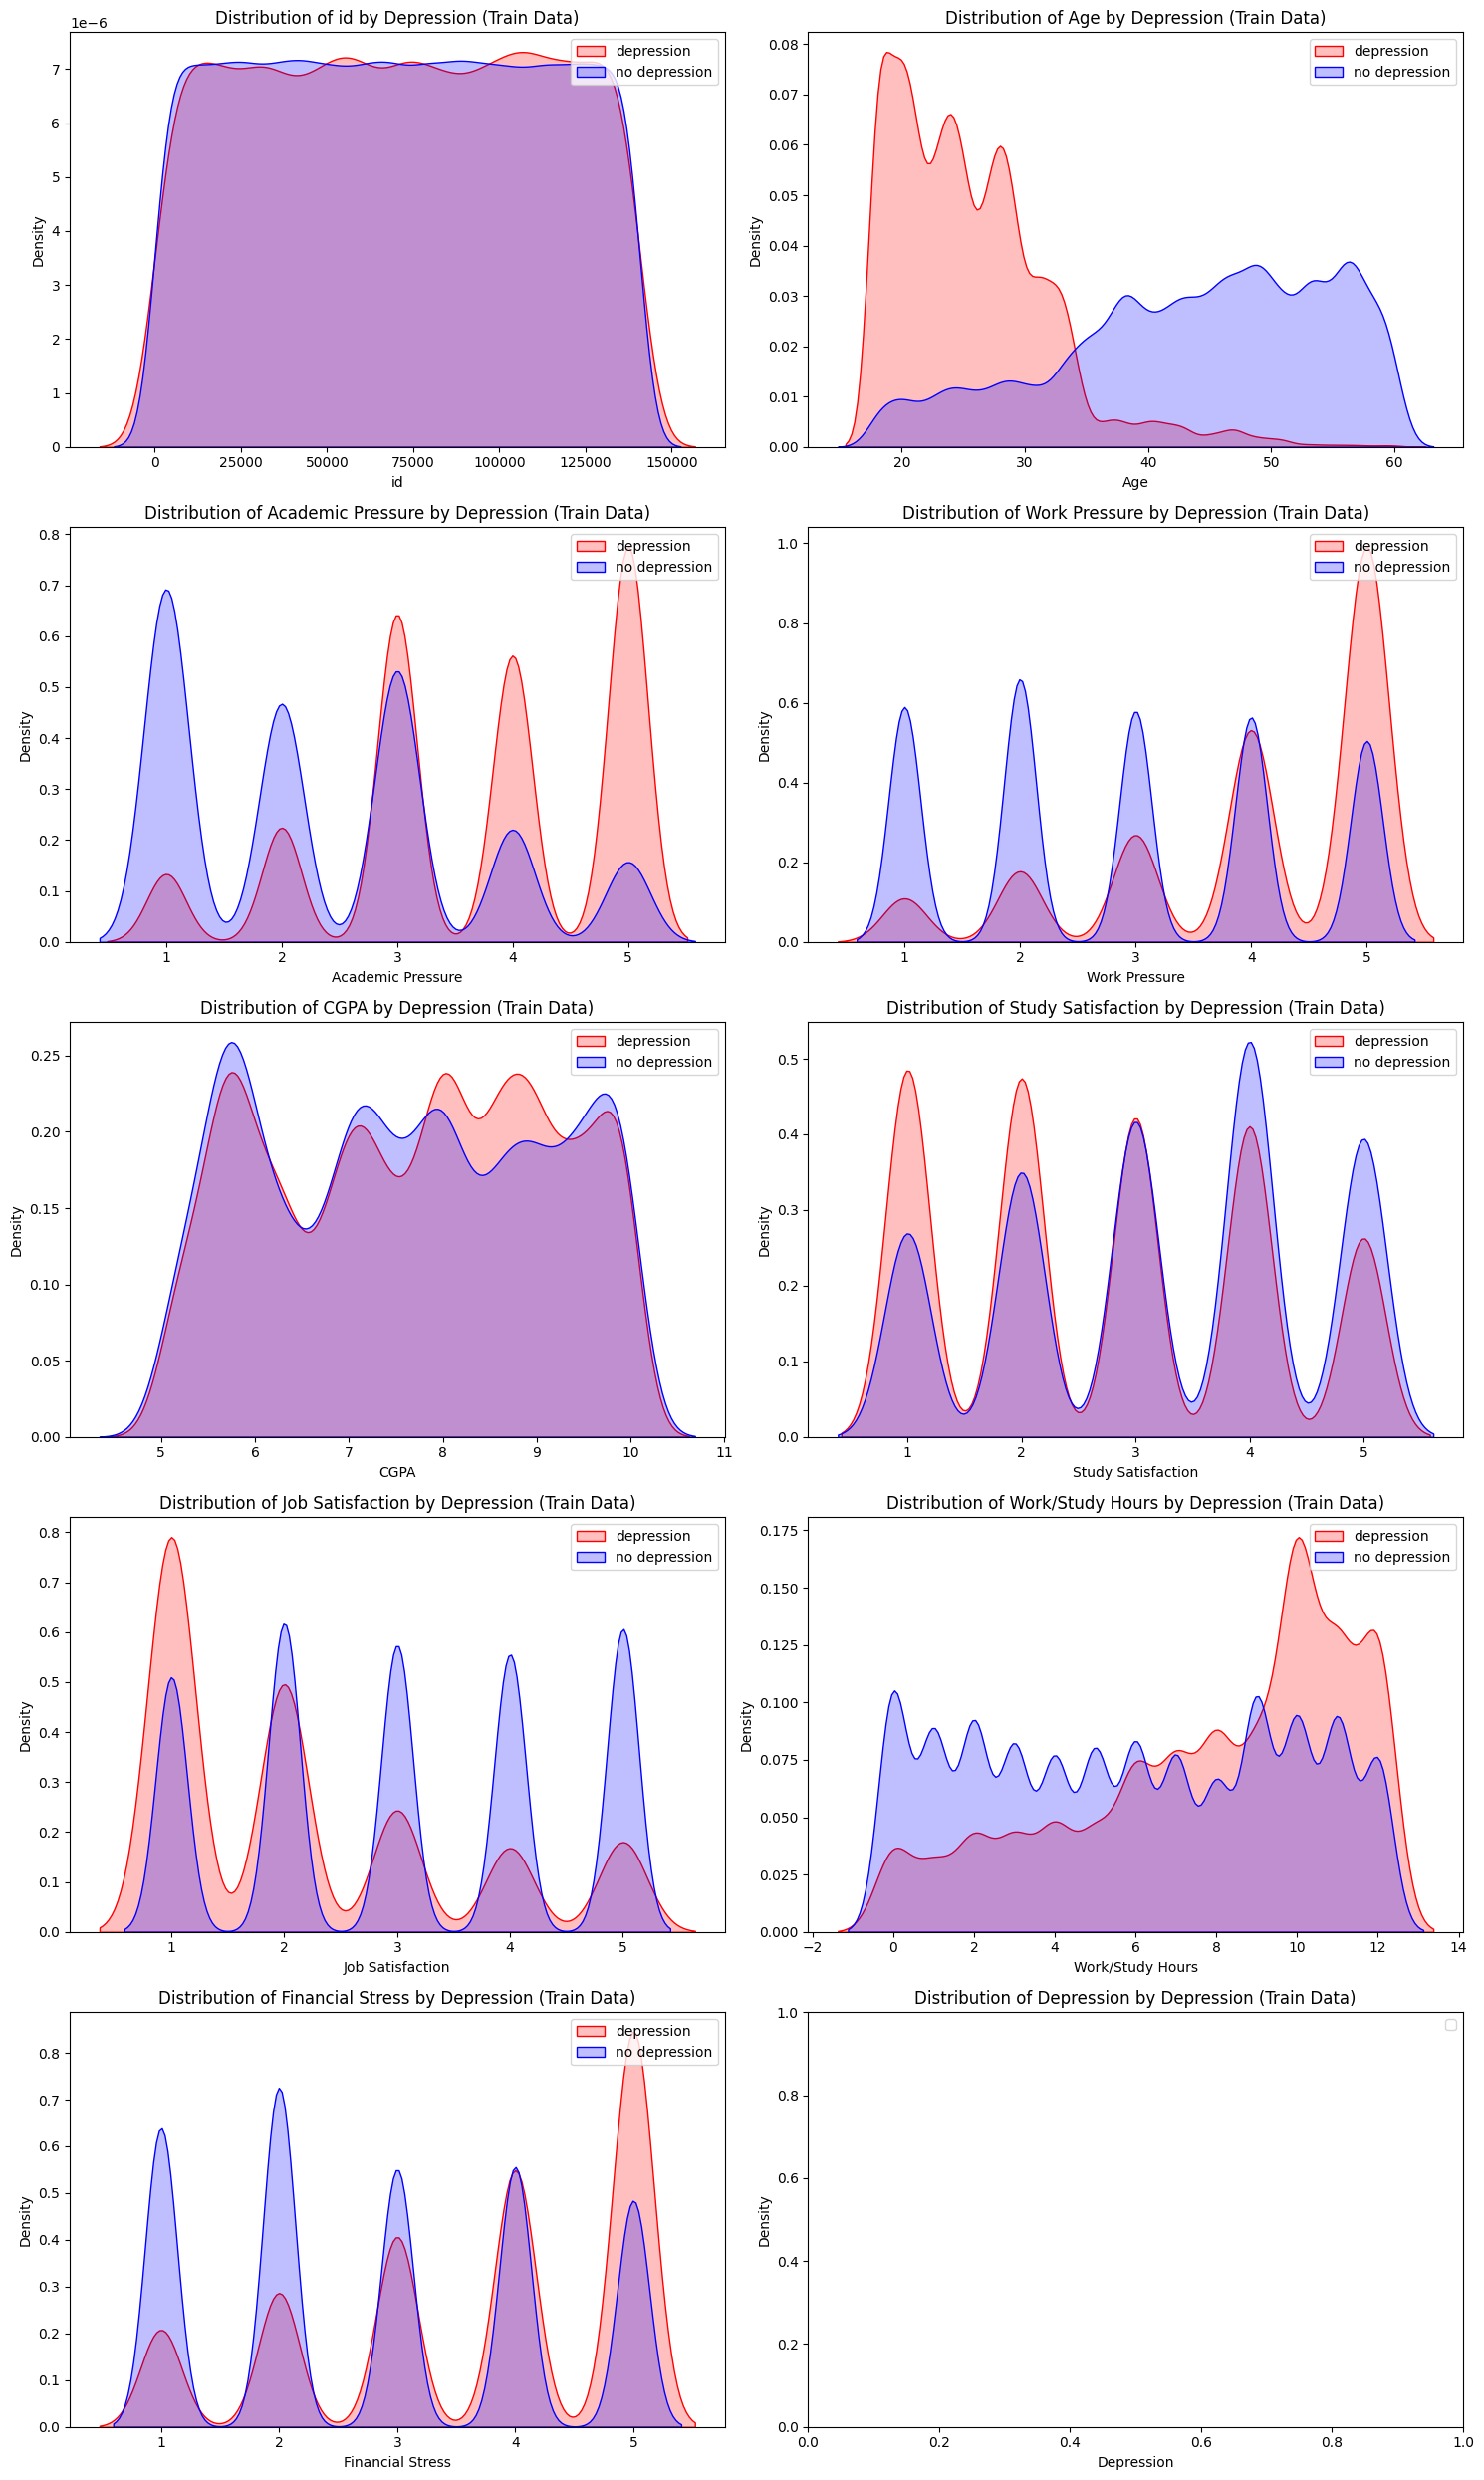

In [14]:
# Select numerical columns
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns

# Set the number of columns for the grid
num_cols = 2
num_rows = (len(numerical_cols) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

# Create a distribution plot for each numerical feature in the training data, separated by depression
for i, col in enumerate(numerical_cols):
    sns.kdeplot(train[train.Depression == 1][col], ax=axes[i], color='red', label='depression', fill=True)
    sns.kdeplot(train[train.Depression == 0][col], ax=axes[i], color='blue', label='no depression', fill=True)
    axes[i].set_title(f'Distribution of {col} by Depression (Train Data)')
    axes[i].legend()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

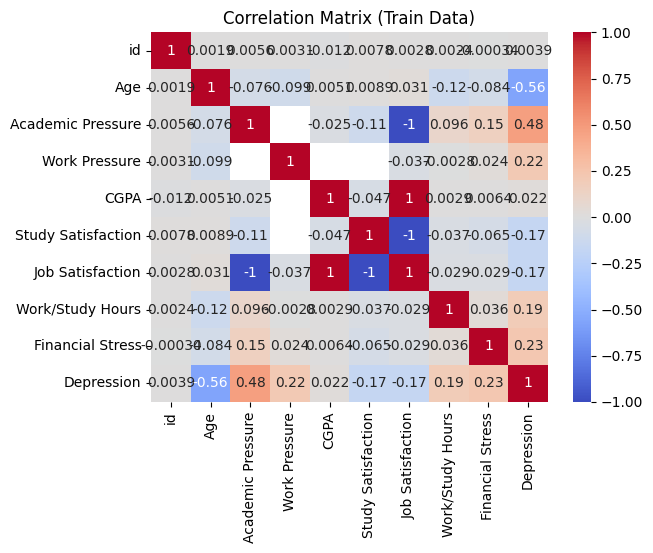

In [15]:
corr_matrix = train[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Train Data)')
plt.show()

<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">OUTLIER DETECTION</p>


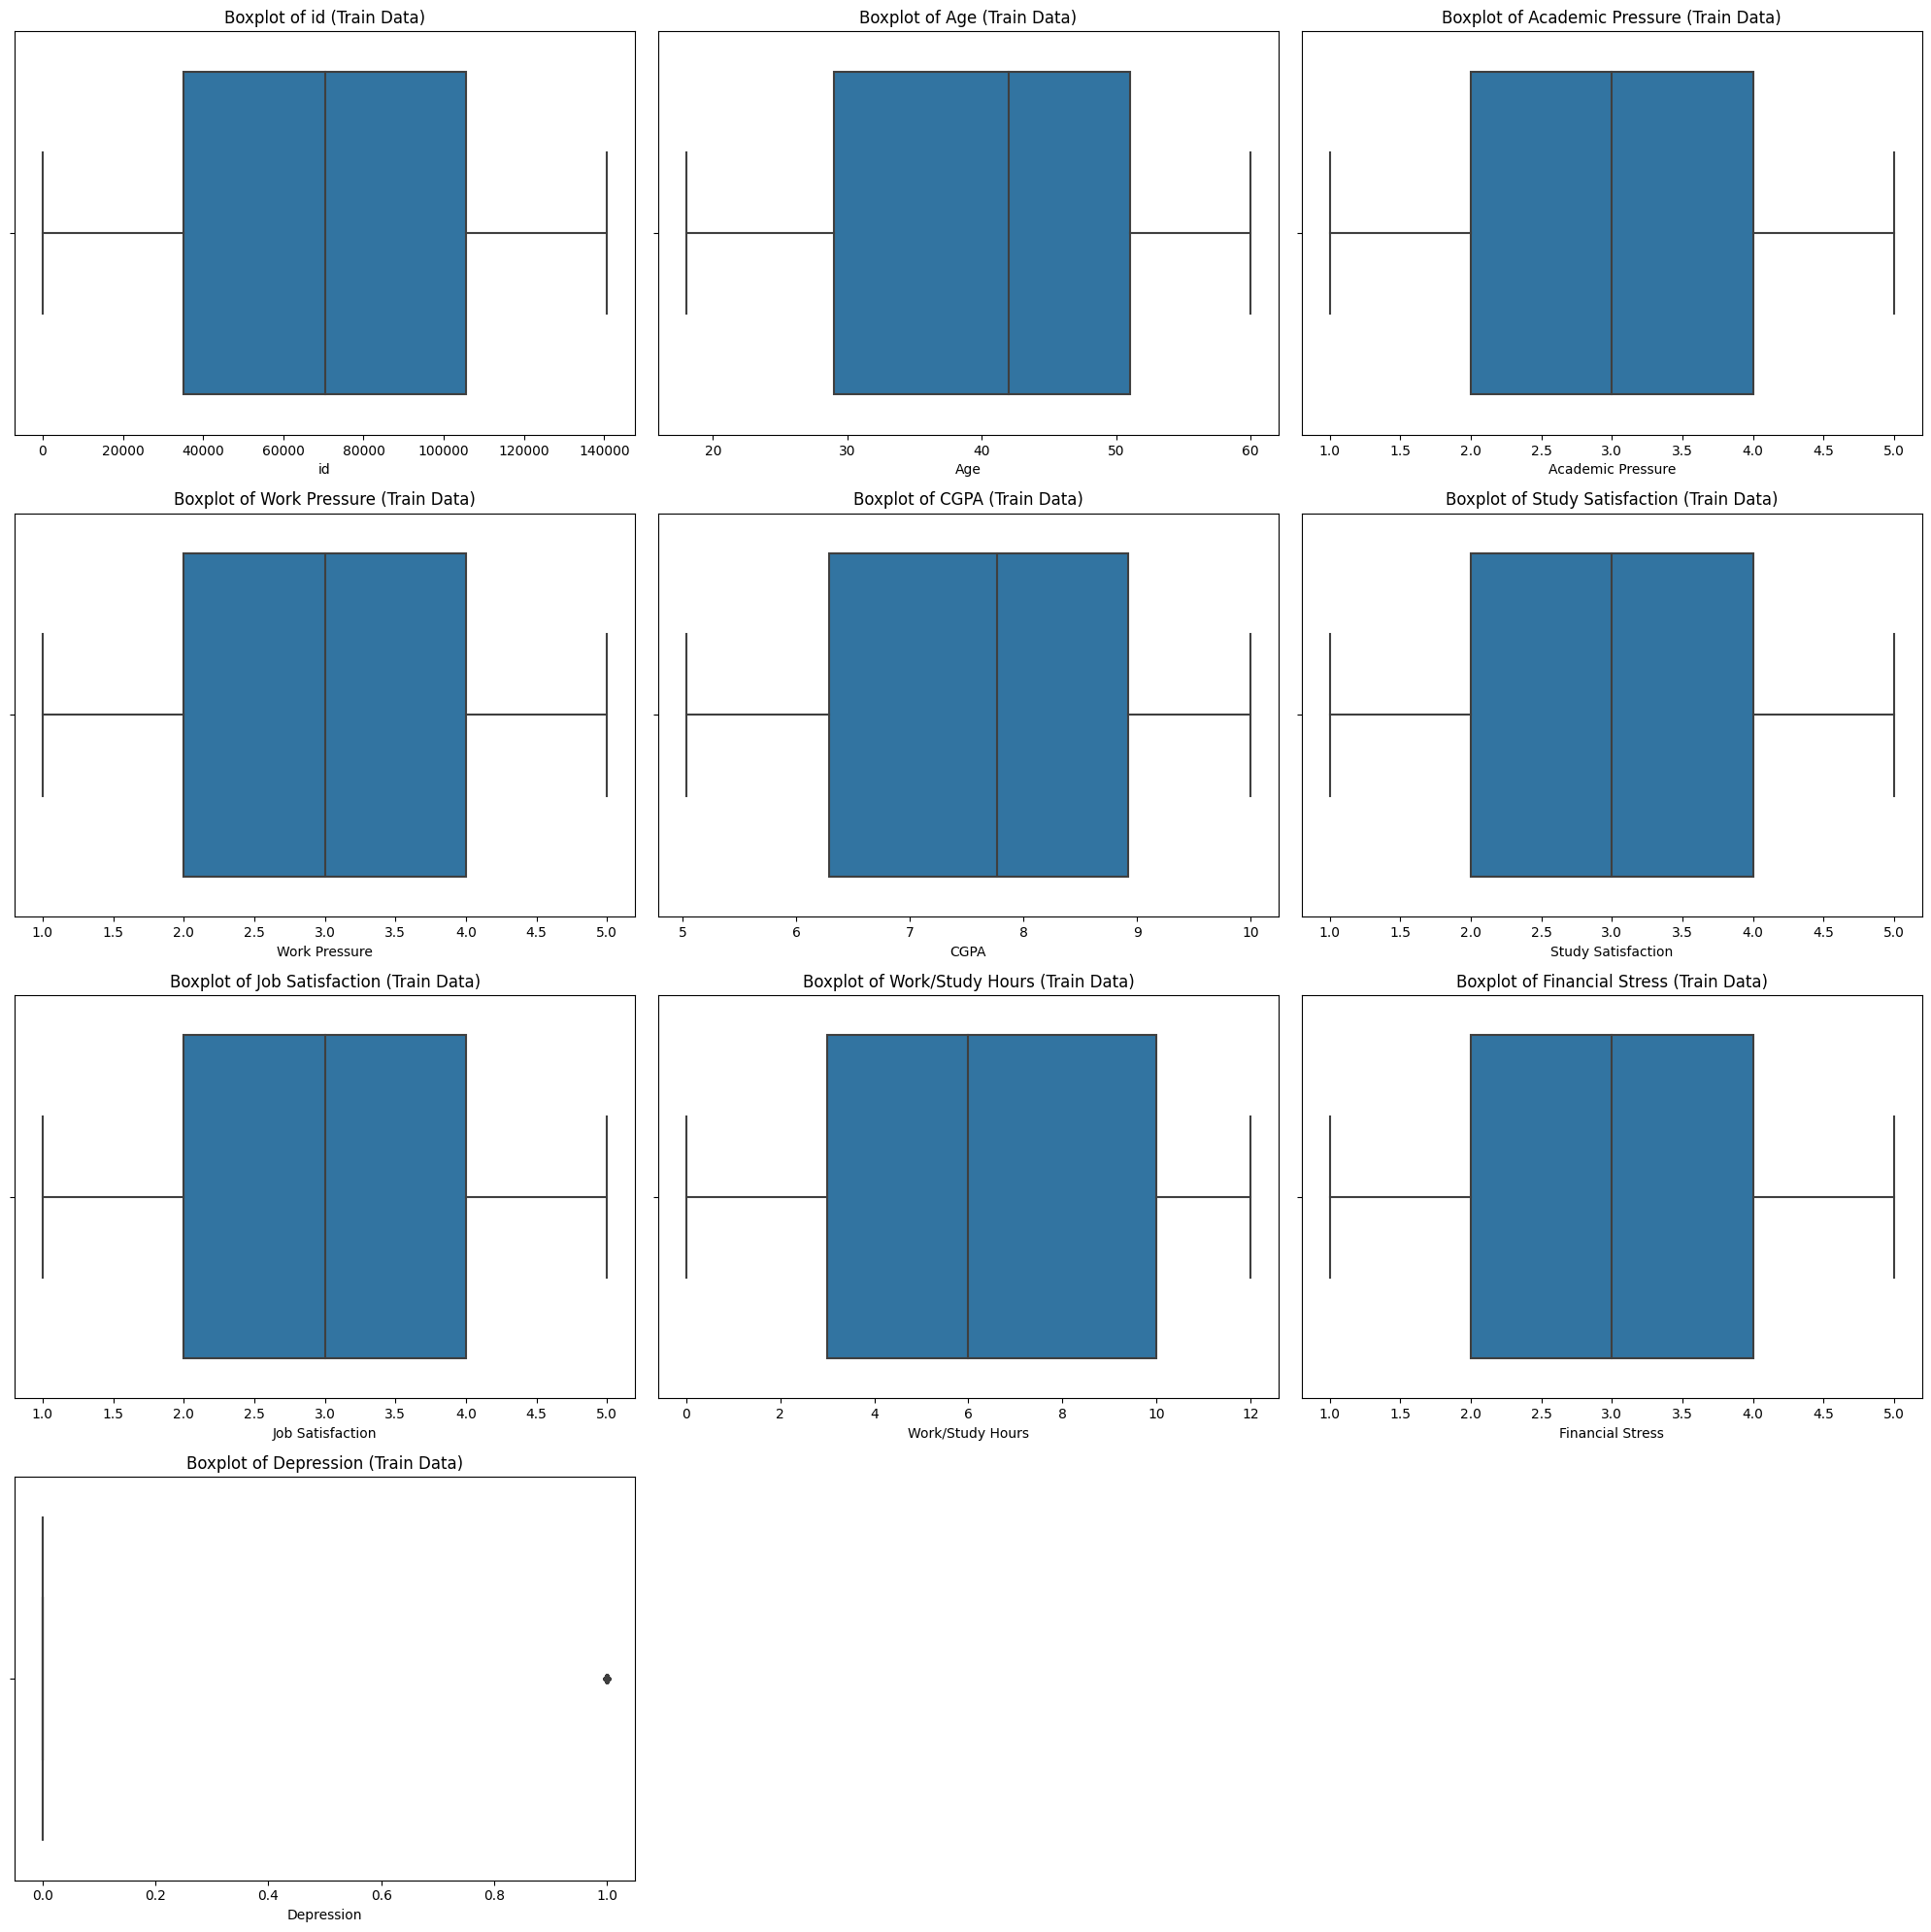

In [16]:

# Select numerical columns
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns

# Set the number of columns for the grid
num_cols = 3
num_rows = (len(numerical_cols) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()

# Create a boxplot for each numerical feature in the training data
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=train[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} (Train Data)')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


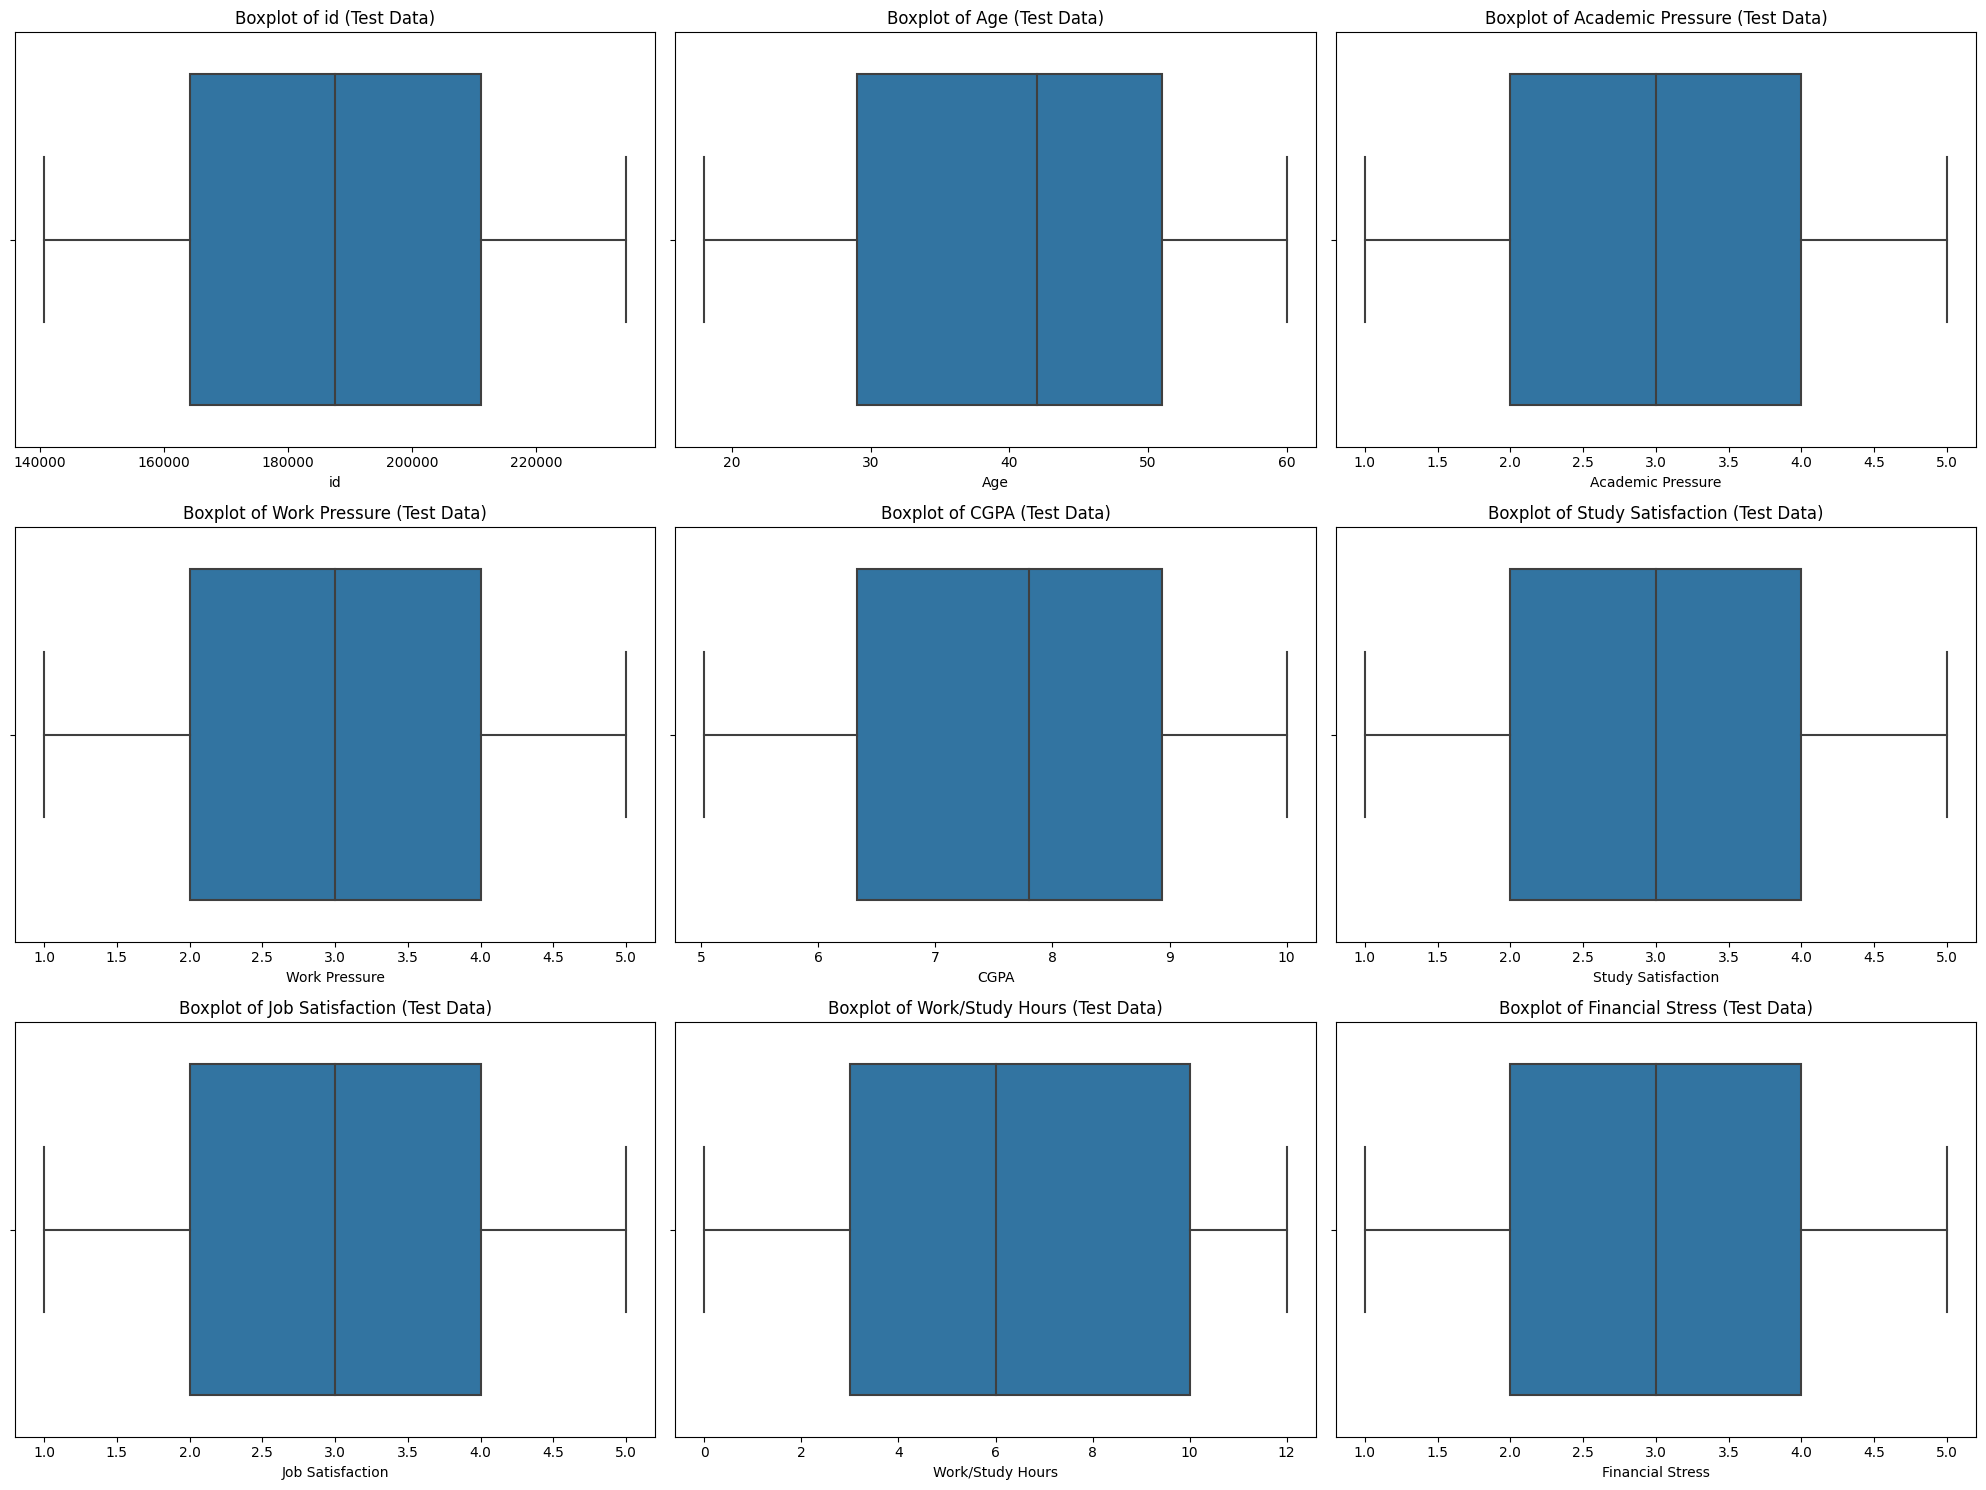

In [17]:

# Select numerical columns
numerical_cols = test.select_dtypes(include=['int64', 'float64']).columns

# Set the number of columns for the grid
num_cols = 3
num_rows = (len(numerical_cols) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()

# Create a boxplot for each numerical feature in the test data
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=test[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} (Test Data)')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">MISSING VALUE COUNT</p>


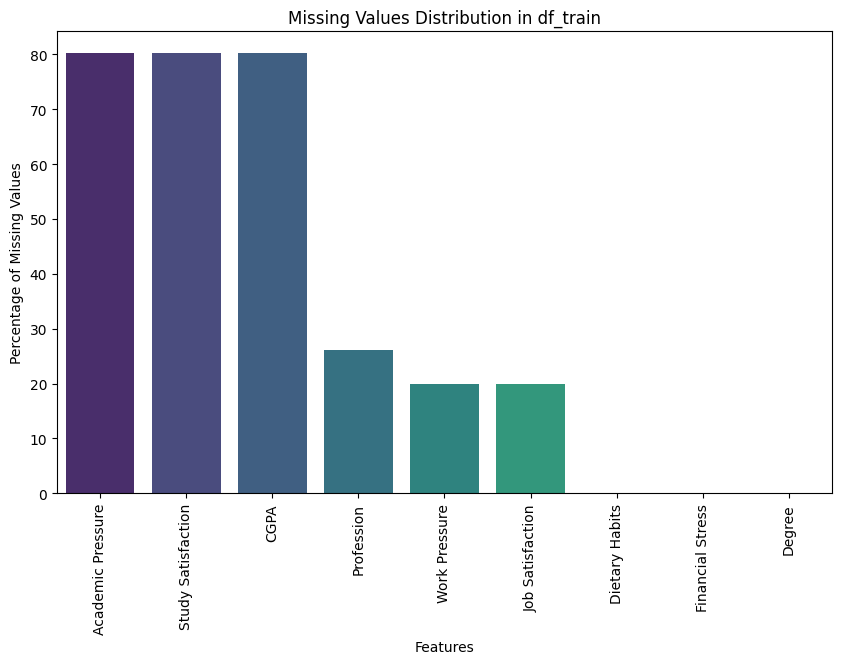

In [18]:
missing_values = train.isnull().mean() * 100
missing_values = missing_values[missing_values >0]
missing_values = missing_values.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values Distribution in df_train')
plt.show()

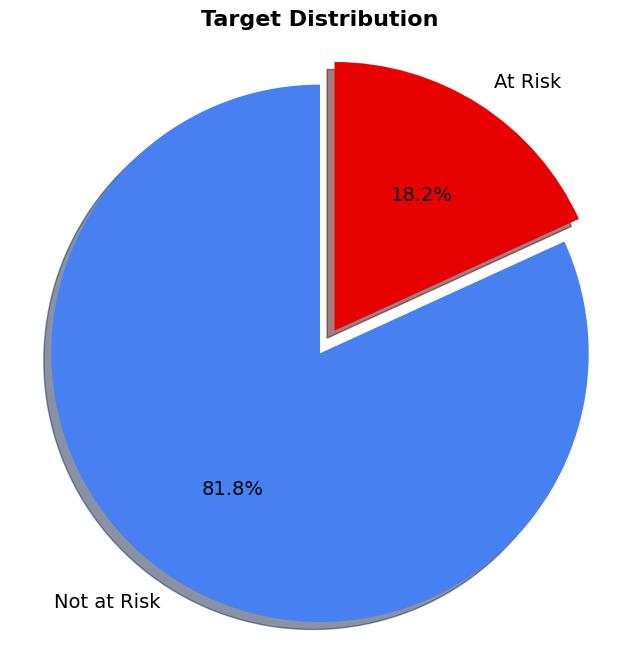

In [19]:
# Define colors for the segments
colors = ['#4780f0', '#e70101']

# Define the explosion for the segments
explode = (0.1, 0)  # Only "explode" the 1st slice (i.e., 'Not at Risk')

# Create the pie chart with enhanced design
plt.figure(figsize=(8, 8))  # Increase the figure size
plt.pie(
    train.Depression.value_counts(),
    labels=['Not at Risk', 'At Risk'],
    autopct='%.1f%%',
    colors=colors,
    explode=explode,
    shadow=True,
    startangle=90,
    textprops={'fontsize': 14}  # Increase the font size of labels
)

plt.title('Target Distribution', fontsize=16, fontweight='bold')  # Customize title
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


# this is the imbalanced distribution

<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">ENCODING + OULIER REMOVE</p>

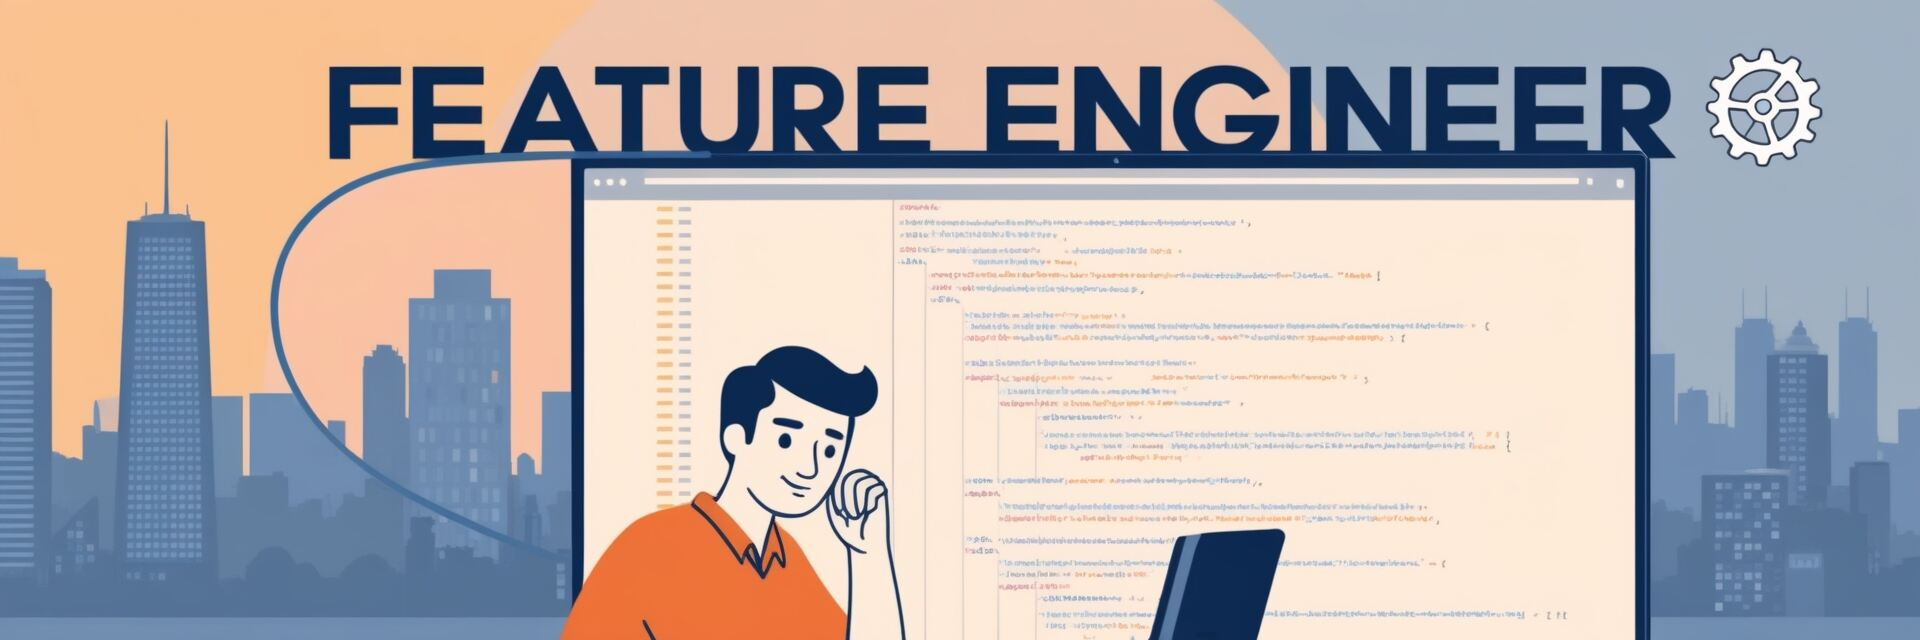

In [20]:
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


In [21]:
df_train=train
df_test=test

In [22]:
# Drop 'id' and 'name' columns
df_train = df_train.drop([ 'id','Name'], axis=1)

# Define the target column
target_column = 'Depression'

# Select categorical columns
categorical_columns = df_train.select_dtypes(include=['object']).columns

# Select numerical columns, excluding the target column 
numerical_columns = df_train.select_dtypes(exclude=['object']).columns.drop(target_column)

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
rs = 42

# Step 1: Convert categorical columns to 'category' dtype
df_train[categorical_columns] = df_train[categorical_columns].astype('category')
df_test[categorical_columns] = df_test[categorical_columns].astype('category')

# Define target before modifying df_train
y_train = df_train[target_column]

# Step 2: Define preprocessing pipelines
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler()),
    ('convert_to_float32', FunctionTransformer(lambda x: x.astype(np.float32)))
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
    ('ordinal', OrdinalEncoder(dtype=np.int32, handle_unknown='use_encoded_value', unknown_value=-1))
])

# Step 3: Combine the numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ]
)

# Step 4: Apply the transformations to the training and test sets
X_train_preprocessed = preprocessor.fit_transform(df_train)
X_test_preprocessed = preprocessor.transform(df_test) 

# Step 5: Apply Isolation Forest for outlier detection on the training data
isolation_forest = IsolationForest(contamination=0.01, random_state=rs)
outlier_labels = isolation_forest.fit_predict(X_train_preprocessed)

# Step 6: Filter out outliers from both X_train_preprocessed and y_train
non_outliers_mask = outlier_labels != -1
X_train_preprocessed = X_train_preprocessed[non_outliers_mask]
y_train = y_train[non_outliers_mask]

<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">TRAIN_TEST_SPLIT</p>

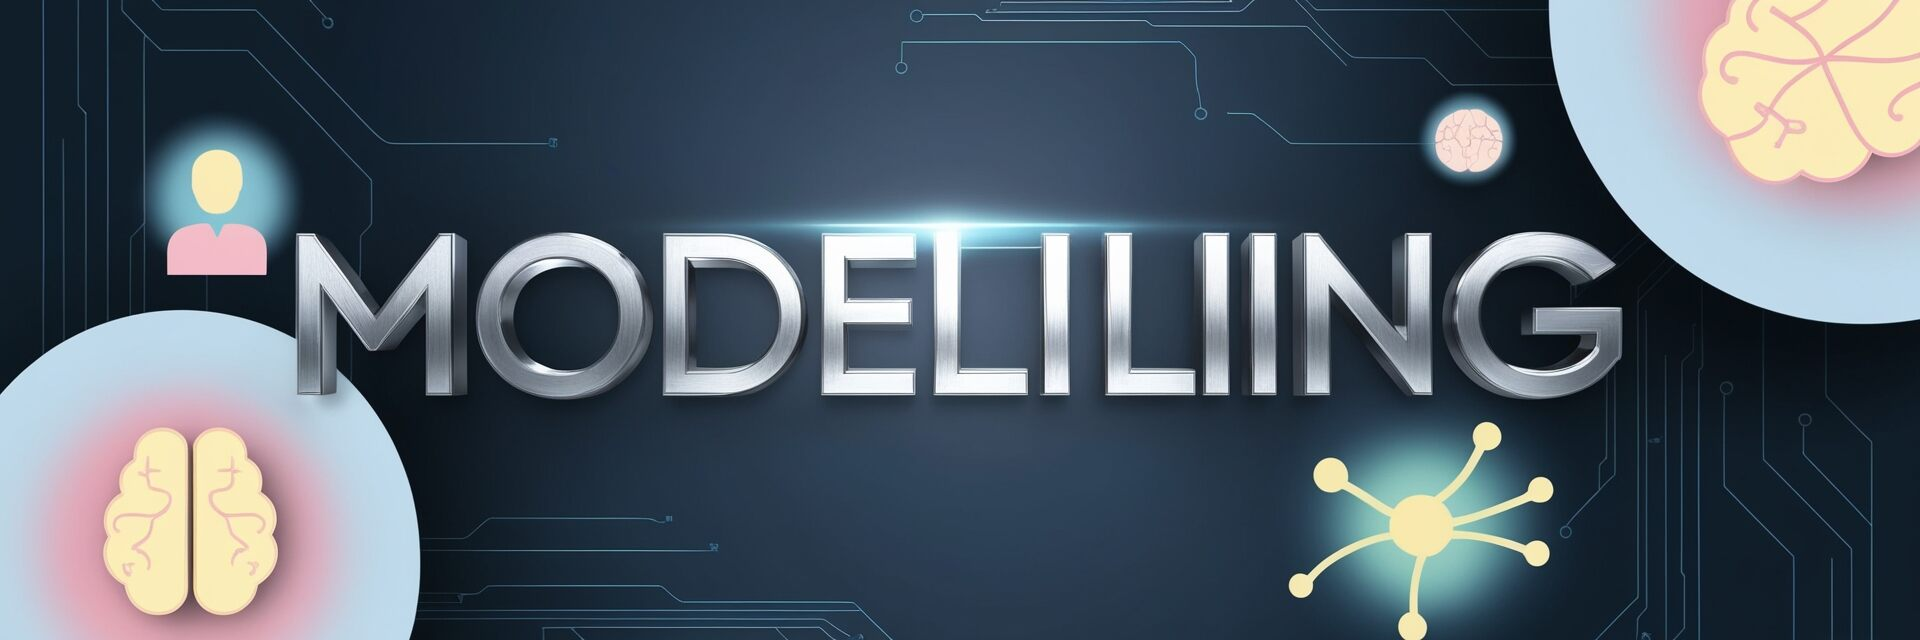

In [24]:
# Step 7: Perform train-test split on the processed data
X_train, X_val, y_train, y_val = train_test_split(X_train_preprocessed, y_train, test_size=0.2, random_state=rs)


<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">LAZY PREDICT</p>


In [25]:
!pip3 install -U lazypredict
import lazypredict
from lazypredict.Supervised import LazyClassifier

In [26]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     random_state=2024,
                     classifiers='all')

models, predictions = clf.fit(X_train[:100_00] , X_val[:100_00] , y_train[:100_00] , y_val[:100_00])

 97%|█████████▋| 28/29 [00:24<00:00,  2.19it/s]

[LightGBM] [Info] Number of positive: 1781, number of negative: 8219
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 446
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.178100 -> initscore=-1.529274
[LightGBM] [Info] Start training from score -1.529274


100%|██████████| 29/29 [00:25<00:00,  1.15it/s]


In [27]:
# Sort the DataFrame by the 'accuracy' column in descending order
sorted_models = models.sort_values(by="Accuracy", ascending=False)

# Apply the style
sorted_models[:29].style.set_properties(**{
    "background-color": "lightblue", 
    "color": "darkblue", 
    "border": "2px solid #ff5733"
})


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
CalibratedClassifierCV,0.939300,0.886757,0.886757,0.938688,1.577558
AdaBoostClassifier,0.939300,0.890923,0.890923,0.938954,0.471673
LinearSVC,0.938800,0.887330,0.887330,0.938275,0.417358
LogisticRegression,0.938600,0.886770,0.886770,0.938059,0.072621
SVC,0.937400,0.883408,0.883408,0.936761,1.826855
LGBMClassifier,0.937000,0.885577,0.885577,0.936547,0.258389
ExtraTreesClassifier,0.936500,0.872994,0.872994,0.935230,0.924145
SGDClassifier,0.934800,0.856393,0.856393,0.932430,0.115418
RandomForestClassifier,0.934100,0.873945,0.873945,0.933153,1.057018


<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">TEST WITH ADABOOST</p>


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Use a Decision Tree as the base estimator
base_estimator = DecisionTreeClassifier(max_depth=2)

# Initialize AdaBoost with a customized base estimator
ada_clf = AdaBoostClassifier(
    base_estimator=base_estimator,
    n_estimators=100,  # Increase the number of estimators
    learning_rate=0.5,  # Adjust learning rate
    random_state=42
)

ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_val, y_pred))


Accuracy: 0.9396963279371119
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     22861
           1       0.84      0.82      0.83      4998

    accuracy                           0.94     27859
   macro avg       0.90      0.89      0.90     27859
weighted avg       0.94      0.94      0.94     27859



<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">VOTING CLASSIFIER</p>


In [34]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

ensemble = VotingClassifier(estimators=[
    ('ada', AdaBoostClassifier(n_estimators=100, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
], voting='soft')

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Accuracy with ensemble :", accuracy)


Accuracy with ensemble : 0.9399475932373739


In [30]:
# Assuming `best_xgb` is your trained model
accuracy_optuna = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy_optuna)

Validation Accuracy: 0.9399475932373739


<a id="dataset-analysis"></a>
# <p style="padding:10px;background-color:#2e3b4e;margin:0;color:#e8e8e8;font-family:Arial,sans-serif;font-size:110%;text-align:center;border-radius:10px;overflow:hidden;font-weight:600">FEATURE IMPORTANCE</p>


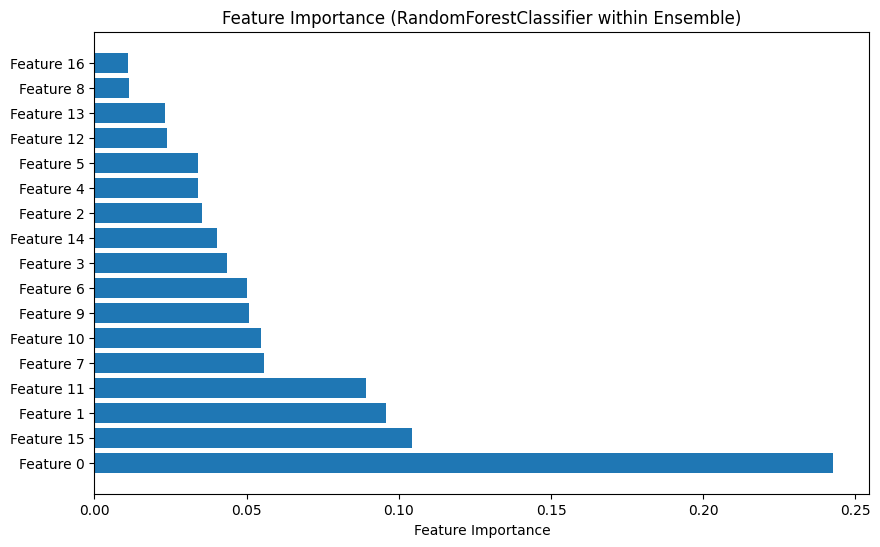

In [37]:
rf_model = ensemble.named_estimators_['rf']
importances = rf_model.feature_importances_

if isinstance(X_train, np.ndarray):
    feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]
else:
    feature_names = X_train.columns

sorted_idx = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_idx]
sorted_feature_names = np.array(feature_names)[sorted_idx]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance (RandomForestClassifier within Ensemble)')
plt.barh(np.arange(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(np.arange(len(sorted_importances)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.show()